## Notebook 6: Image classifier using ResNet50

To address our problem statement of building an image classifier to identify 12 classes of hawker food, we will be building two groups of models as follows: 

- Group 1: Own convolutional neural network (CNN) model with its respective layers (e.g. Conv2D, MaxPool2D, Dropout, Dense layers)
- Group 2: Transfer learning using pre-trained models (i.e. MobileNetV2, VGG16, ResNet50) for feature extraction and prediction. 

In Notebook 3, we have built our own CNN model by detailing the necessary layers (e.g. Conv2D, MaxPool2D, dropout, Dense layers). For Notebooks 4-6, we will be shifting our focus to look at transfer learning using pre-trained models. Specifically, we will be looking at MobileNet, ResNet50 and VGG16 as pre-trained models to help with feature extraction and classification thereafter. As pre-trained models have been trained on 1000 classes of images from ImageNet, they are good at detecting high-level features like edges, patterns etc. This thus helps in quicker convergence (and often with high accuracy), making it the preferred approach to tasks like object detection.  

### 6.1: Importing libraries and setting parameters

In [1]:
#Importing the necessary libraries
import os
import sys 
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=sys.maxsize)

In [2]:
#Instructing Jupyter notebook to use GPU when running ResNet50
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')


# As ResNet requires special pre-processing of images, we will also import the necessary input
from keras.applications.resnet import preprocess_input

In [3]:
#Setting out the necessary parameters to train our model
img_width, img_height = 224, 224 
train_data_dir = '../Datasets/Final/Training'
validation_data_dir = '../Datasets/Final/Validation'
test_data_dir= '../Datasets/Final/Test'
batch_size = 32
num_train = 12000
num_validation = 2400

### 6.2: Data augmentation

To prevent any overfitting in our model, we will undertake data augmentation to aritifically created more images out of the exisiting 12,000 training images that we have. Main techniques used include rotation, shifting images upwards/downward or left/right, horizontal flip, zooming in/out at random etc.([*Source: Nanonets*](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/)).


In [4]:

# Data augmentation our 12,000 training images
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                 rotation_range=20,
                 width_shift_range=0.1,
                 height_shift_range=0.1,
                 shear_range=0.1,
                 zoom_range=0.1,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 preprocessing_function=preprocess_input)

# Data augmentation our 2,400 validation images (note: only rescale for these images)
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input)

# Function that reads images from our designated training path and augmenting the images
# within as per our data augementation parameters above 
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Function that reads images from our designated validation path and augmenting the images
# within as per our data augementation parameters above 
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Map index to class names
classes = dict((v, k.replace('_', ' ').title()) for k, v in train_generator.class_indices.items())

Found 12000 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

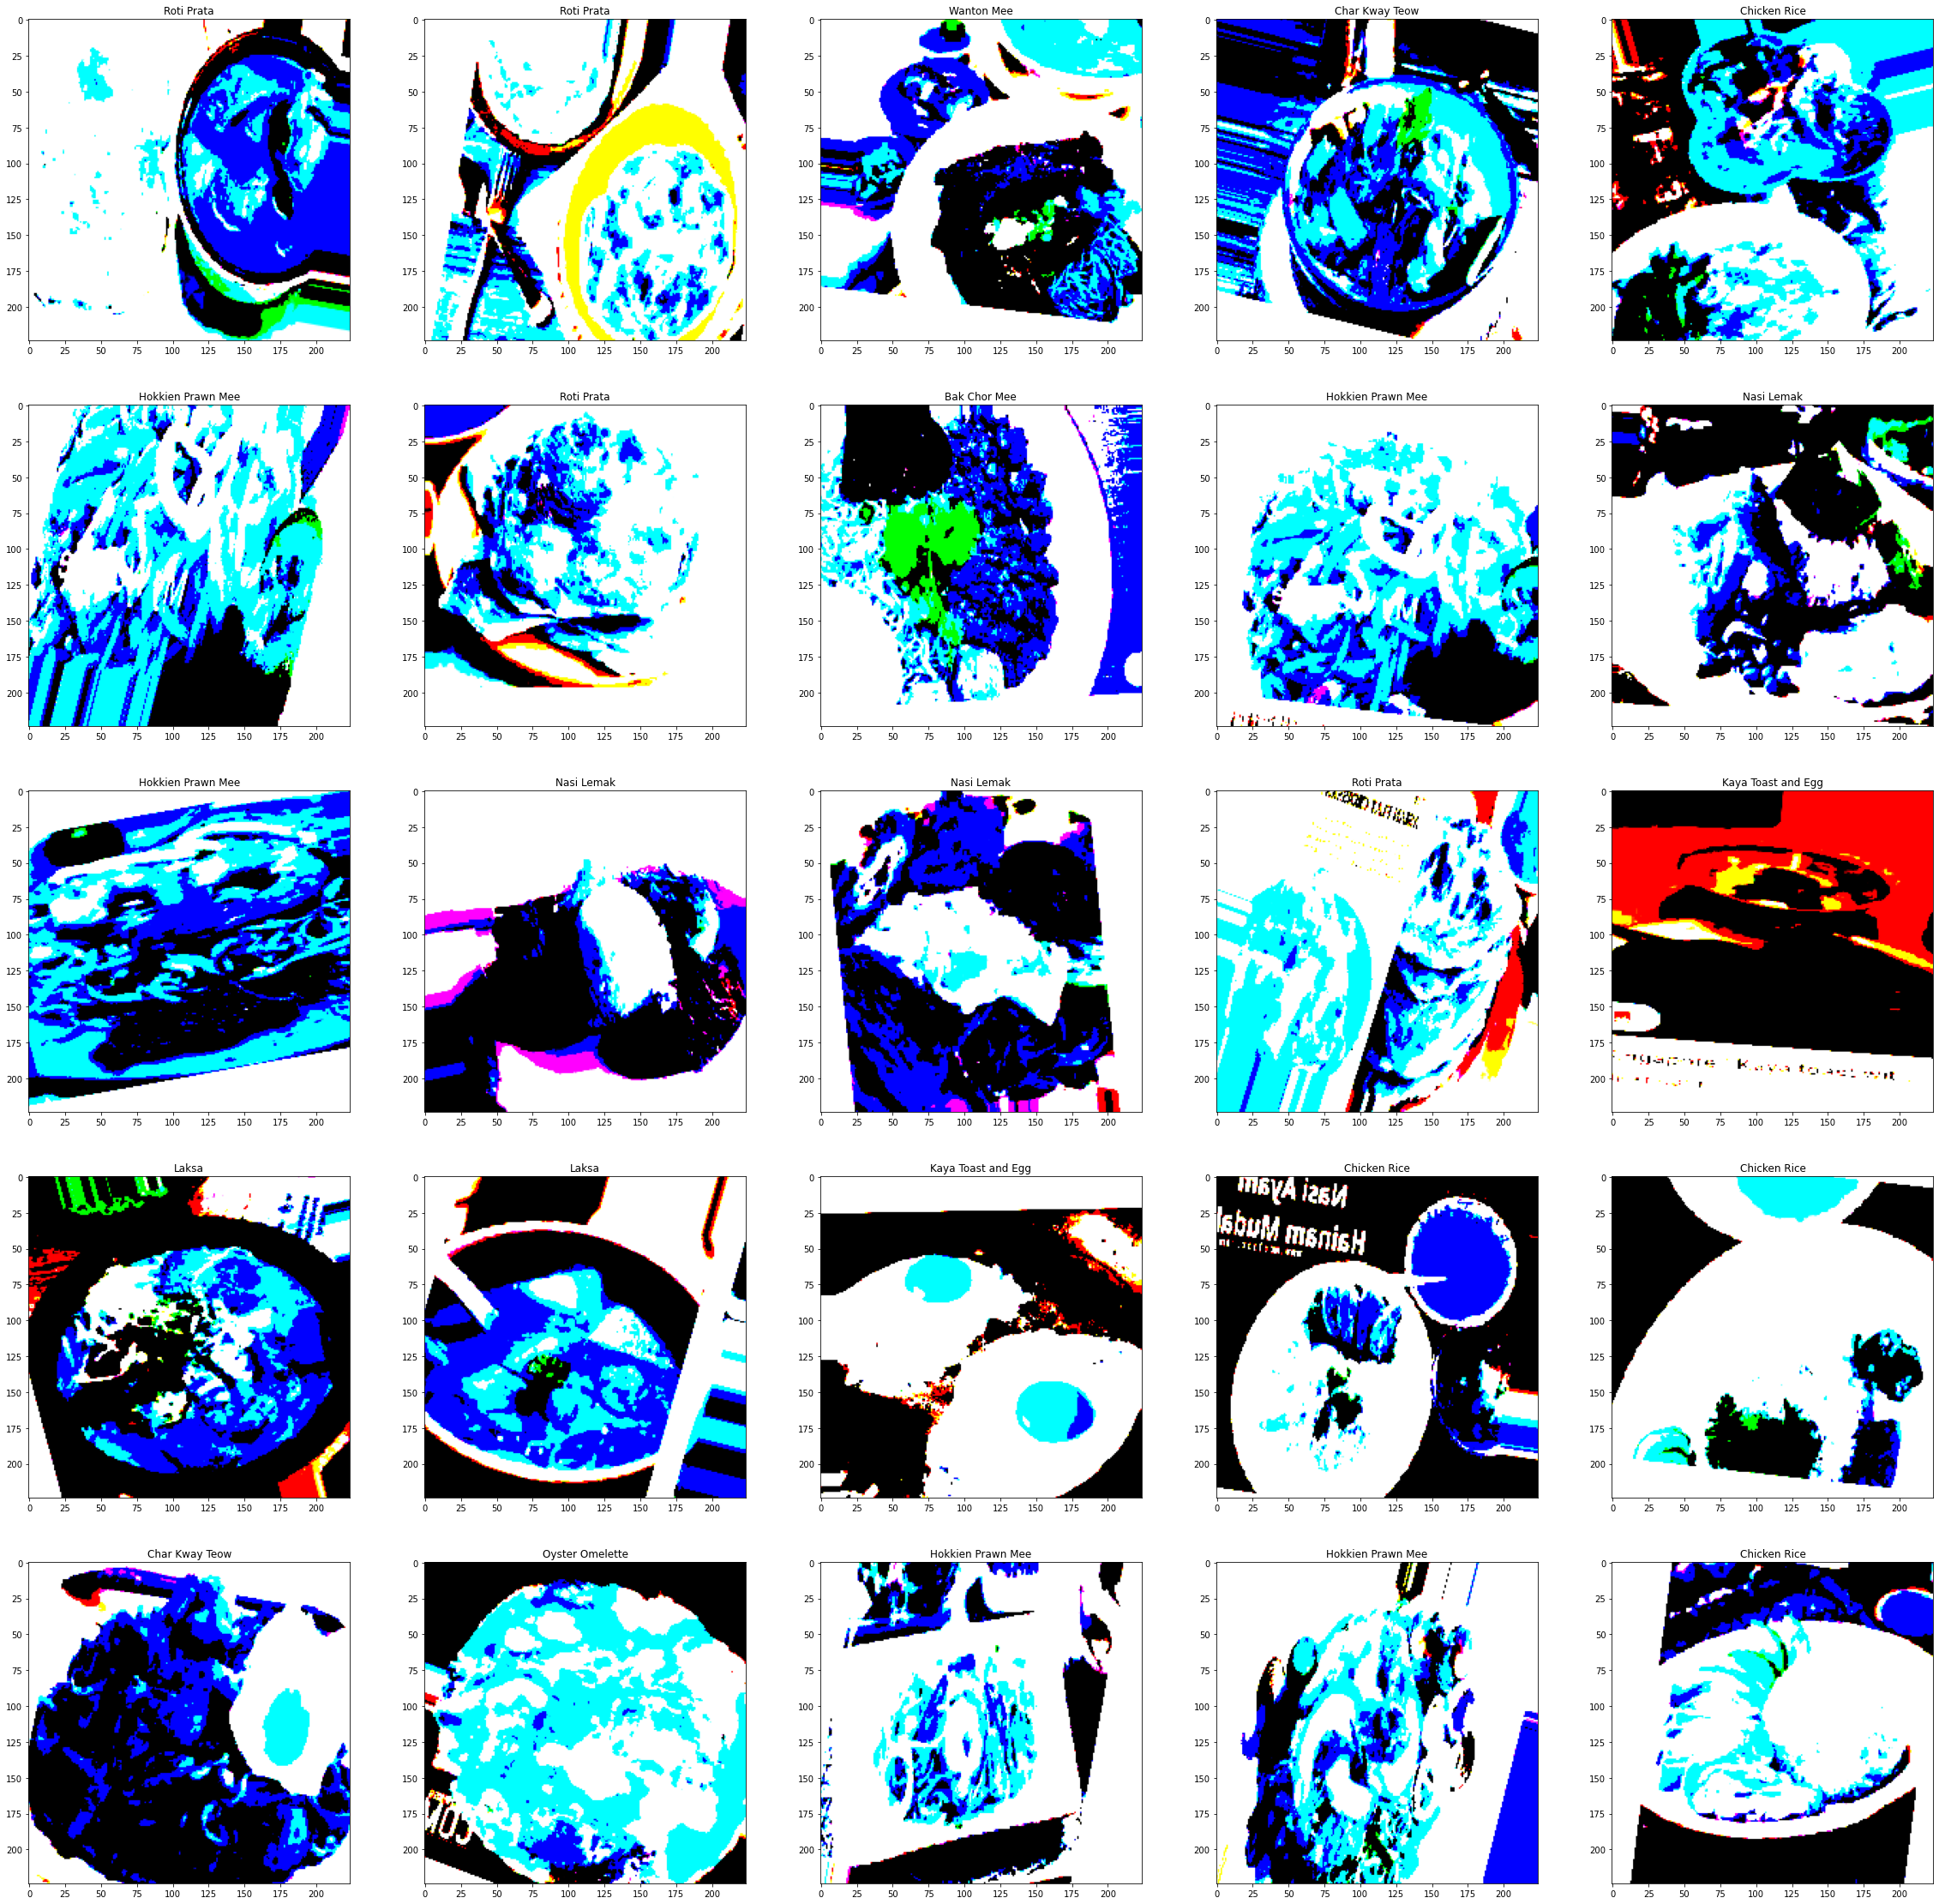

In [5]:
#Preview of images in train_generator
row = 5;column = 5
n=0
classtolabel = {'0':'Bak Chor Mee',"1":'Char Kway Teow', 
                "2":'Chicken Rice', "3":'Hokkien Prawn Mee', "4":'Kaya Toast and Egg', 
                "5":"Laksa", "6": "Nasi Lemak", "7": "Oyster Omelette", "8":"Roast Meat Rice", 
                "9": "Roti Prata", "10":"Satay", "11":"Wanton Mee"}
for x in train_generator:
    fig, axes = plt.subplots(row,column,figsize=(40,40))
    for i in range(row):
        for j in range(column):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

### 6.3: Transfer learning with ResNet50

Similar to Mobilenet and VGG16, we intend to use transfer learning for feature extration and will first have to create our base model (minus the top classifier layer). 

In [6]:
# Creating our base model from the pre-trained ResNet model
base_model = keras.applications.ResNet50(input_shape=(img_width, img_height, 3),
                                            include_top=False,
                                            weights='imagenet')
# Freezing all but the last classifier layer to prevent weights from ResNet50 from being updated 
base_model.trainable = False


In [7]:
# Examinining the base model architecture (i.e. ResNet50 minus top classifier layer)
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
# Definining final model structure (base model from ResNet50 + 2 Dense layers of our choosing)
model = keras.Sequential([base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(512, activation = "relu",kernel_initializer='he_normal'),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(12, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2())])                          

In [9]:
# Compiling our final model with a learning rate of Adam, 0.0001
top3_acc = keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy')
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc])

In [10]:
# Examinining the final model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                6156      
Total params: 24,642,956
Trainable params: 1,055,244
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
# Setting our final model to train on 100 epochs first 
initial_epochs = 100

#We also include an early stopping callback to stop the model from training after 3 epochs 
#if val_loss is not decreasing 
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

# Train model with early stopping
history = model.fit_generator(
    train_generator,
    epochs=initial_epochs,
    steps_per_epoch=num_train // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation // batch_size,
    callbacks=[callback])


/Users/Derrick/miniforge3/envs/tf3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/100
375/375 [==============================] - ETA: 0s - batch: 187.0000 - size: 32.0000 - loss: 1.6462 - accuracy: 0.5505 - top_3_categorical_accuracy: 0.7884

/Users/Derrick/miniforge3/envs/tf3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


375/375 [==============================] - 181s 473ms/step - batch: 187.0000 - size: 32.0000 - loss: 1.6462 - accuracy: 0.5505 - top_3_categorical_accuracy: 0.7884 - val_loss: 1.1119 - val_accuracy: 0.7275 - val_top_3_categorical_accuracy: 0.9179
Epoch 2/100
375/375 [==============================] - 178s 471ms/step - batch: 187.0000 - size: 32.0000 - loss: 1.1282 - accuracy: 0.7218 - top_3_categorical_accuracy: 0.9113 - val_loss: 0.9960 - val_accuracy: 0.7596 - val_top_3_categorical_accuracy: 0.9279
Epoch 3/100
375/375 [==============================] - 176s 469ms/step - batch: 187.0000 - size: 32.0000 - loss: 1.0106 - accuracy: 0.7592 - top_3_categorical_accuracy: 0.9310 - val_loss: 0.9473 - val_accuracy: 0.7783 - val_top_3_categorical_accuracy: 0.9358
Epoch 4/100
375/375 [==============================] - 181s 483ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.9383 - accuracy: 0.7837 - top_3_categorical_accuracy: 0.9404 - val_loss: 0.9005 - val_accuracy: 0.7983 - val_top_3_categ

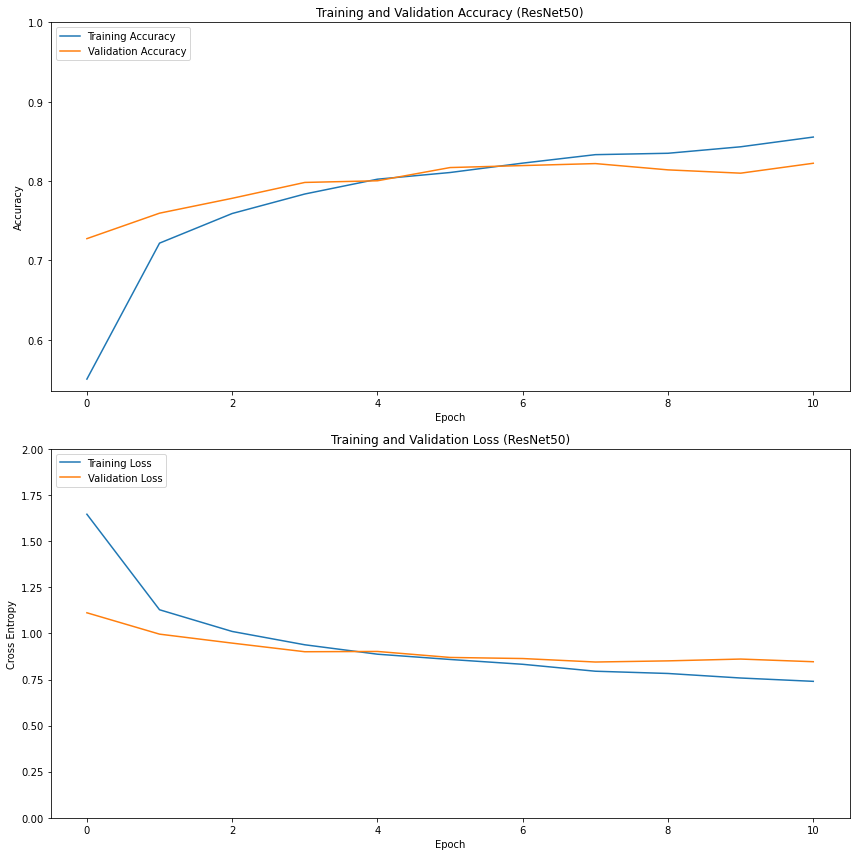

In [12]:
# Plotting accuracies and losses/val_losses of our training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy (ResNet50)')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss (ResNet50)')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

Based on the two graphs above, we are satisfied that there is little overfitting/underfitting since our accuracy and val_accuracy lines quite close to each other. Furthermore, both our loss and val_loss lines have a decent convex shape, thereby suggesting minimisation of our loss function and that we have chosen a good learning rate ([*Source: TowardsDataScience*](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10)).

### 6.4: Fine-tuning of final model

To further improve the accuracy of our final model, we will now unfreeze a few of the top layers of the base model to jointly train both the newly-added classifier layers and the last layers of the base model.

In [13]:
#Unfreezing top layers of base model to allow for training
base_model.trainable = True

# Examining how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tuning to start from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  175


In [14]:
# Compiling the model using a much lower training rate
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate/10),
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc])

# Examining model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                6156      
Total params: 24,642,956
Trainable params: 20,508,172
Non-trainable params: 4,134,784
_________________________________________________________________


In [15]:
first_epochs = len(history.history['val_loss'])

fine_tune_epochs = 100
total_epochs =  first_epochs + fine_tune_epochs

# Continue model training 
history_fine_tune = model.fit_generator(
    train_generator,
    epochs=total_epochs,
    initial_epoch = first_epochs,
    steps_per_epoch=num_train // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation // batch_size,
    callbacks=[callback])

Epoch 12/111
375/375 [==============================] - 279s 734ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.7006 - accuracy: 0.8670 - top_3_categorical_accuracy: 0.9718 - val_loss: 0.8449 - val_accuracy: 0.8221 - val_top_3_categorical_accuracy: 0.9550
Epoch 13/111
375/375 [==============================] - 283s 747ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.6992 - accuracy: 0.8677 - top_3_categorical_accuracy: 0.9728 - val_loss: 0.8355 - val_accuracy: 0.8229 - val_top_3_categorical_accuracy: 0.9513
Epoch 14/111
375/375 [==============================] - 282s 748ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.6977 - accuracy: 0.8671 - top_3_categorical_accuracy: 0.9714 - val_loss: 0.8265 - val_accuracy: 0.8300 - val_top_3_categorical_accuracy: 0.9542
Epoch 15/111
375/375 [==============================] - 281s 744ms/step - batch: 187.0000 - size: 32.0000 - loss: 0.7059 - accuracy: 0.8650 - top_3_categorical_accuracy: 0.9705 - val_loss: 0.8473 - val_accuracy: 0.8171 -

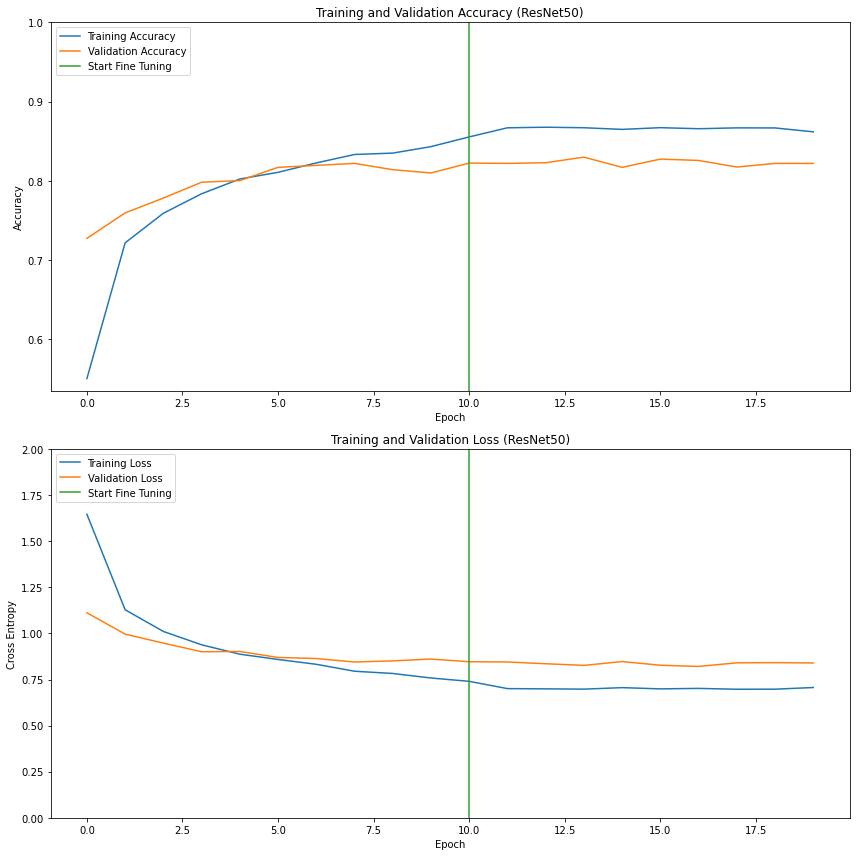

In [16]:
# Plotting accuracies and losses/val_losses of our training and validation sets after fine-tuning

acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']

loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.plot([first_epochs-1,first_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (ResNet50)')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([first_epochs-1,first_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss (ResNet50)')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [17]:
# Saving our final model  
model.save('./final_model_resnet50.h5')     
          

### 6.5: Prediction and evaluation

To prevent data leakage, we will be evaluating our model using our test set which our model has not seen before (i.e. hold-out set).

In evaluating our model, we will primarily be focusing on its accuracy (i.e. ratio of number of correction predictions to the total number of input images).

In [18]:
# Create  our test generator on our test set (which our model has never seen before) in a single batch 
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=2400,
    class_mode='categorical')

Found 2400 images belonging to 12 classes.


In [19]:
#Generating the true and predicted labels of our test images and evaluating the accuracy score
x_test, y_test = test_generator.next()
y_pred_conf = model.predict(x_test) 
y_pred = np.argmax(y_pred_conf,axis=1)
y_true = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_true,y_pred)*100))

Accuracy score: 82.8%


Our final model (with ResNet50 as transfer learning) yields an accuracy score of 73.4% when evaluated using our test set. This means that 73.4% (or ~1762 out of 2400 test images) are accurately classified into their respective hawker food classes.

In line with our evaluation metrix, we have ultimately chosen to go with our ResNet50 model (out of all 4 models we have developed) as it has the highest test accuracy. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


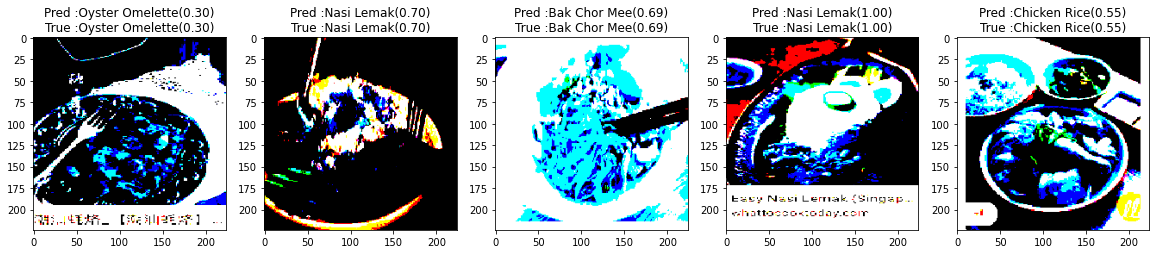

In [20]:
# Printing 5 random images from our test_generator together with their predicted and true labels
ind = np.random.randint(1,len(x_test),5)
fig, axis =plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    axis[i].imshow(x_test[j])
    axis[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_true[j])],y_pred_conf[j][(y_true[j])],fontweight="bold", size=20))

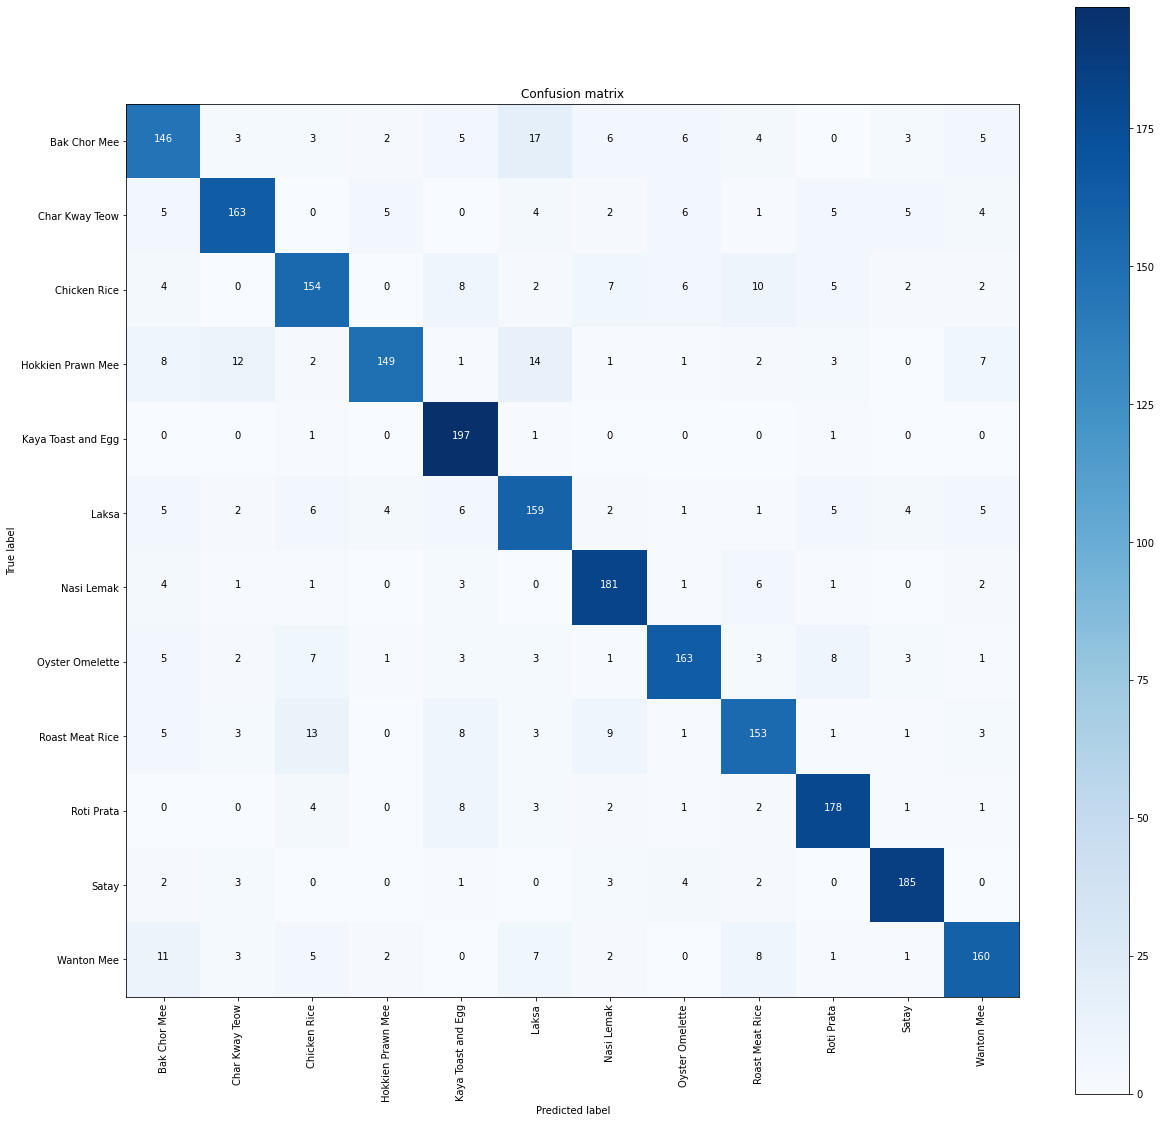

In [21]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    classes = ['Bak Chor Mee', 'Char Kway Teow', 
                'Chicken Rice', 'Hokkien Prawn Mee','Kaya Toast and Egg',
               "Laksa", "Nasi Lemak", "Oyster Omelette", "Roast Meat Rice", "Roti Prata", "Satay", "Wanton Mee"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
classes = ['Bak Chor Mee', 'Char Kway Teow', 
                'Chicken Rice', 'Hokkien Prawn Mee','Kaya Toast and Egg',
               "Laksa", "Nasi Lemak", "Oyster Omelette", "Roast Meat Rice", "Roti Prata", "Satay", "Wanton Mee"]

plt.figure(figsize=(20, 20))   
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=classes, title='Confusion matrix')

From the confusion matrix above, we can observe that our ResNet50 model is generally good at predicting the correct classes since Bak Chor Mee (despite having the lowest accuracy amongst all food classes) has 146/200 images correctly classified.

That said, we noticed that our model tends to struggle with noodle-related images (e.g. 17 Bak Chor Mee images inaccurately prediced as Laksa or 14 Hokkien Prawn Mee images as Laksa). This phenomenon is also observed in other models that we have built. To overcome this and as a possible extension to our project, we can consider collecting and training our CNN model on even more images so that it gets better at recognising and predicting noodle-related images.

### 6.6: Misclassified images

In [25]:
# find the wrong-est label (largest confidence wrong label)- codes taken from Riley 
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_true = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_true != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_true[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 5
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

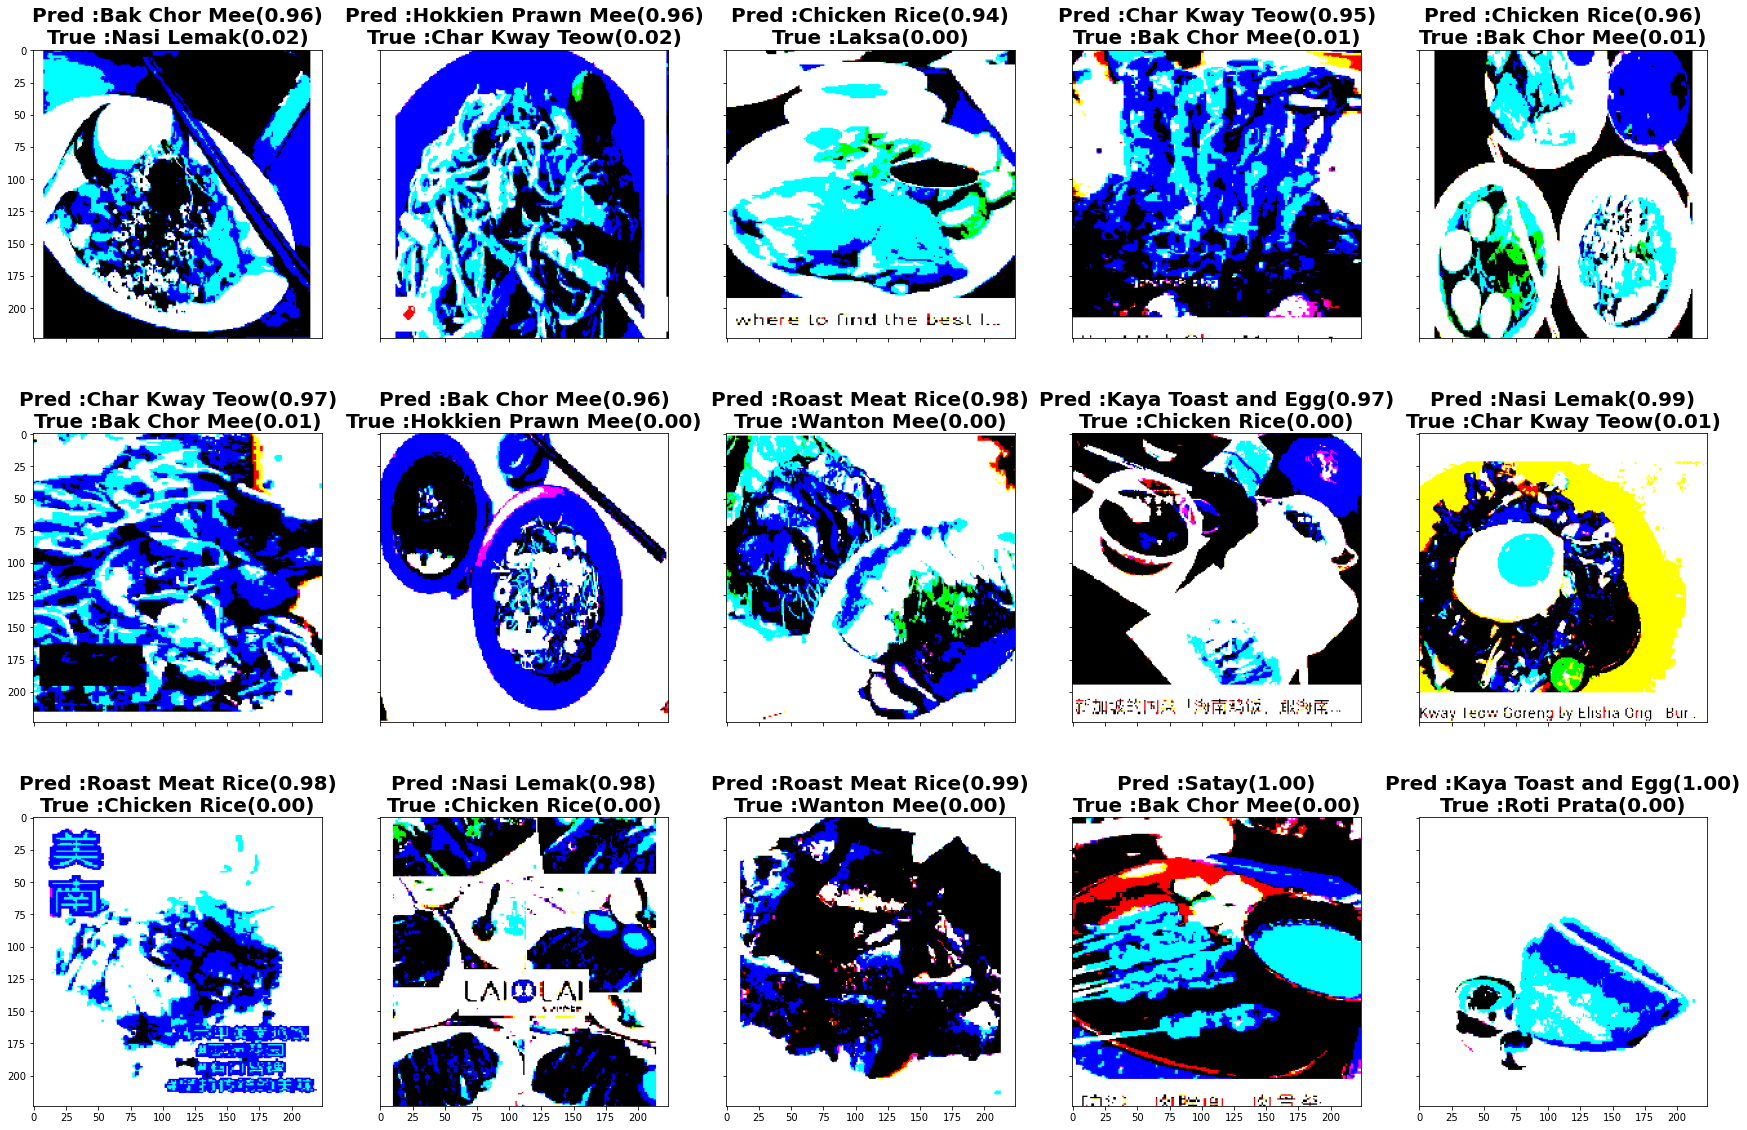

In [26]:
show_wrongest_label(x_test,y_test,y_pred_conf)

The images above supplement our understanding of our model's limitation by showing us the images with the "wrongest" predictions. This will aid in our future improvement work of the model. 